<a href="https://colab.research.google.com/github/albertopolini/Advanced-Machine-Learning/blob/main/AutoEncoders_VS_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Representation Learning


## Autoencoders VS Principal Component Analysis 


Why using Autoencoders (AEs)?

- Neural nets are very flexible, therefore we can introduce non-linearities by using non-linear activation functions;

- with an increasing amount of features, PCA will result in slower processing compared with an AE.



In [1]:
import keras
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint
import tensorflow
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from sklearn import datasets
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics


%matplotlib inline

RANDOM_SEED = 37117
np.random.seed(RANDOM_SEED)

### Import Data and Preprocessing


The **Iris flower data set** is a multivariate data set introduced by the British statistician and biologist Ronald Fisher in his 1936 paper. The data set consists of 50 samples from each of three species of Iris (Iris Setosa, Iris virginica, and Iris versicolor). Four features were measured from each sample: the *length* and the *width* of the *sepals* and *petals*, in centimeters.


<img src="https://miro.medium.com/max/1003/1*2uGt_aWJoBjqF2qTzRc2JQ.jpeg" width="65%">


In [2]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [3]:
def plot3clusters(X, title, vtitle):
  plt.figure()
  colors = ['navy', 'turquoise', 'darkorange']
  lw = 2

  for color, i, target_name in zip(colors, [0, 1, 2], target_names):
      plt.scatter(X[y == i, 0], X[y == i, 1], color=color, alpha=1., lw=lw,
                  label=target_name)
  plt.legend(loc='best', shadow=False, scatterpoints=1)
  plt.title(title)  
  plt.xlabel(vtitle + "1")
  plt.ylabel(vtitle + "2")
  plt.show()

### Compute PCA


In [4]:
pca = decomposition.PCA(n_components=2)
pca

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [5]:
pca_transformed = pca.fit_transform(X_scaled)
pca_transformed

array([[-6.30702931e-01,  1.07577910e-01],
       [-6.22904943e-01, -1.04259833e-01],
       [-6.69520395e-01, -5.14170597e-02],
       [-6.54152759e-01, -1.02884871e-01],
       [-6.48788056e-01,  1.33487576e-01],
       [-5.35272778e-01,  2.89615724e-01],
       [-6.56537790e-01,  1.07244911e-02],
       [-6.25780499e-01,  5.71335411e-02],
       [-6.75643504e-01, -2.00703283e-01],
       [-6.45644619e-01, -6.72080097e-02],
       [-5.97408238e-01,  2.17151953e-01],
       [-6.38943190e-01,  3.25988375e-02],
       [-6.61612593e-01, -1.15605495e-01],
       [-7.51967943e-01, -1.71313322e-01],
       [-6.00371589e-01,  3.80240692e-01],
       [-5.52157227e-01,  5.15255982e-01],
       [-5.77053593e-01,  2.93709492e-01],
       [-6.03799228e-01,  1.07167941e-01],
       [-5.20483461e-01,  2.87627289e-01],
       [-6.12197555e-01,  2.19140388e-01],
       [-5.57674300e-01,  1.02109180e-01],
       [-5.79012675e-01,  1.81065123e-01],
       [-7.37784662e-01,  9.05588211e-02],
       [-5.

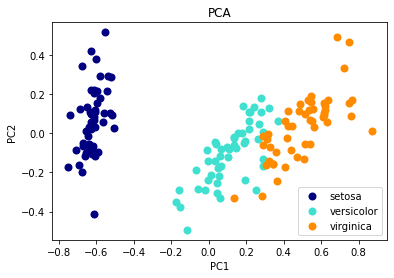

In [6]:
plot3clusters(pca_transformed[:,:2], 'PCA', 'PC')  

### Compute Linear Autoencoder

The encoding and decoding layers have '*linear activations*' and the hidden layer has two neurons. Essentially this structure approximates PCA by reducing the data from four features to two features in the hidden layer. As you can see the model converges quite nicely and our validation loss has dropped to zero. 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 10        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 12        
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________
None


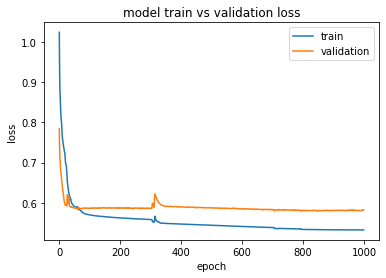

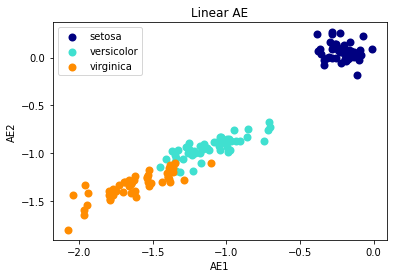

In [7]:
#create an AE and fit it with our data using 3 neurons in the dense layer using keras' functional API
input_dim = X_scaled.shape[1]
encoding_dim = 2  
input_vec = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='linear')(input_vec)
decoded = Dense(input_dim, activation='linear')(encoded)
autoencoder = Model(input_vec, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
print(autoencoder.summary())

history = autoencoder.fit(X_scaled, X_scaled,
                epochs=1000,
                batch_size=16,
                shuffle=True,
                validation_split=0.1,
                verbose = 0)

#plot our loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# use our encoded layer to encode the training input
encoder = Model(input_vec, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_data = encoder.predict(X_scaled)

plot3clusters(encoded_data[:,:2], 'Linear AE', 'AE')  


### Compute Non-Linear Autoencoder

We will replace linear activation functions with a sigmoid. This network structure can be thought of PCA with non-linear transformation.

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 12        
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________
None


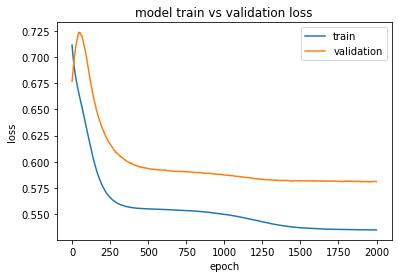

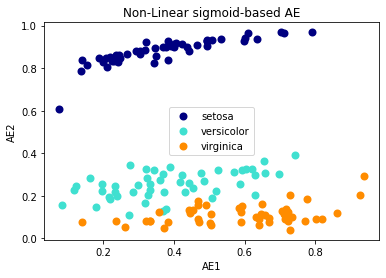

In [8]:
#create an AE and fit it with our data using 3 neurons in the dense layer using keras' functional API
input_dim2 = X_scaled.shape[1]
encoding_dim2 = 2  
input_vec2 = Input(shape=(input_dim2,))
encoded2 = Dense(encoding_dim2, activation='sigmoid')(input_vec2)
decoded2 = Dense(input_dim2, activation='sigmoid')(encoded2)
autoencoder2 = Model(input_vec2, decoded2)
autoencoder2.compile(optimizer='adam', loss='binary_crossentropy')
print(autoencoder2.summary())

history2 = autoencoder2.fit(X_scaled, X_scaled,
                epochs=2000,
                batch_size=16,
                shuffle=True,
                validation_split=0.1,
                verbose = 0)

#plot our loss 
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# use our encoded layer to encode the training input
encoder2 = Model(input_vec2, encoded2)
encoded_input2 = Input(shape=(encoding_dim2,))
decoder_layer2 = autoencoder2.layers[-1]
decoder2 = Model(encoded_input2, decoder_layer2(encoded_input2))
encoded_data2 = encoder2.predict(X_scaled)

plot3clusters(encoded_data2[:,:2], 'Non-Linear sigmoid-based AE', 'AE')  


### Compute Non-Linear Autoencoder with ReLu

We will replace linear activation functions with relu activation and an L1 regularizer. 

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 12        
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________
None


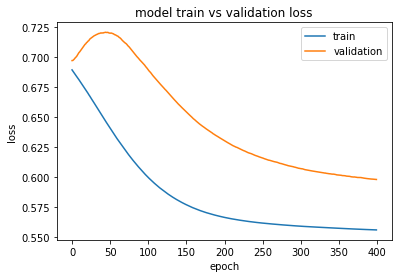

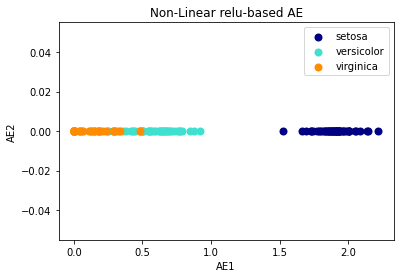

In [9]:
#create an AE and fit it with our data using 3 neurons in the dense layer using keras' functional API
input_dim3 = X_scaled.shape[1]
encoding_dim3 = 2  
input_vec3 = Input(shape=(input_dim3,))
encoded3 = Dense(encoding_dim3, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_vec3)
decoded3 = Dense(input_dim3, activation='sigmoid')(encoded3)
autoencoder3 = Model(input_vec3, decoded3)
autoencoder3.compile(optimizer='adam', loss='binary_crossentropy')
print(autoencoder3.summary())

history3 = autoencoder3.fit(X_scaled, X_scaled,
                epochs=400,
                batch_size=16,
                shuffle=True,
                validation_split=0.1,
                verbose = 0)

#plot our loss 
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# use our encoded layer to encode the training input
encoder3 = Model(input_vec3, encoded3)
encoded_input3 = Input(shape=(encoding_dim3,))
decoder_layer3 = autoencoder3.layers[-1]
decoder3 = Model(encoded_input3, decoder_layer3(encoded_input3))
encoded_data3 = encoder3.predict(X_scaled)

plot3clusters(encoded_data3[:,:2], 'Non-Linear relu-based AE', 'AE')  


### Results Comparison


In [10]:
print('PCA\n',pca_transformed[:,0:2][0:10])
print()
print('Linear AE\n',encoded_data[0:10])
print()
print('Nonlinear AE with sigmoid\n',encoded_data2[0:10])
print()
print('Nonlinear AE with relu\n',encoded_data3[0:10])


PCA
 [[-0.63070293  0.10757791]
 [-0.62290494 -0.10425983]
 [-0.6695204  -0.05141706]
 [-0.65415276 -0.10288487]
 [-0.64878806  0.13348758]
 [-0.53527278  0.28961572]
 [-0.65653779  0.01072449]
 [-0.6257805   0.05713354]
 [-0.6756435  -0.20070328]
 [-0.64564462 -0.06720801]]

Linear AE
 [[-0.20992231  0.10313661]
 [-0.17136109 -0.01602882]
 [-0.1307553   0.0628977 ]
 [-0.15050939  0.00168504]
 [-0.19853264  0.13264675]
 [-0.36588356  0.08756539]
 [-0.16571213  0.07520279]
 [-0.21184997  0.06183021]
 [-0.1008854  -0.02120883]
 [-0.16517654  0.0122738 ]]

Nonlinear AE with sigmoid
 [[0.39911747 0.912792  ]
 [0.22486436 0.83408177]
 [0.23659573 0.86351085]
 [0.19805732 0.8306632 ]
 [0.40682352 0.919968  ]
 [0.5980596  0.92932993]
 [0.26780146 0.8682463 ]
 [0.34657115 0.8943825 ]
 [0.13677347 0.7848407 ]
 [0.24596685 0.8636317 ]]

Nonlinear AE with relu
 [[1.9369242 0.       ]
 [1.7704355 0.       ]
 [1.9197905 0.       ]
 [1.886481  0.       ]
 [2.0075946 0.       ]
 [1.8997185 0.       ]

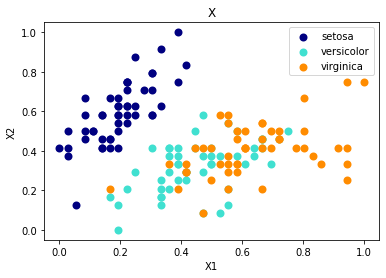

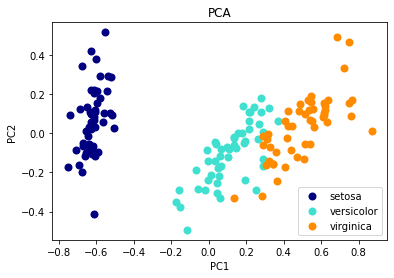

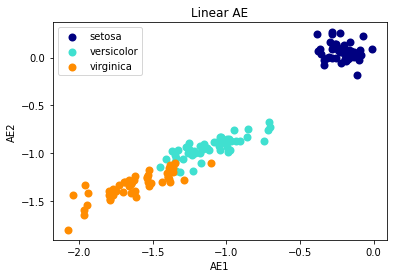

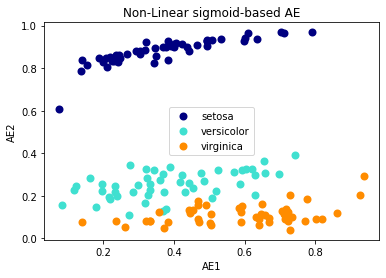

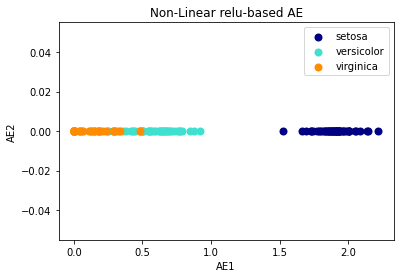

In [11]:
plot3clusters(X_scaled[:,:2], 'X', 'X')  
plot3clusters(pca_transformed[:,:2], 'PCA', 'PC')  
plot3clusters(encoded_data[:,:2], 'Linear AE', 'AE')  
plot3clusters(encoded_data2[:,:2], 'Non-Linear sigmoid-based AE', 'AE')  
plot3clusters(encoded_data3[:,:2], 'Non-Linear relu-based AE', 'AE')  